#### Pakkar

In [0]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, Input, Embedding
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GRU, LSTM
import tensorflow as tf
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
tf.compat.v1.disable_eager_execution()
import warnings; 
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

#### Innlestur gagna

In [0]:
train_data = pd.read_csv('data/train.csv',delimiter=',')

test_data = pd.read_csv('data/test.csv',delimiter=',')
classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

### Ýmsar aðferðir

In [0]:
def calc_scores(y_true_, y_pred_):
    mats = multilabel_confusion_matrix(y_true_, y_pred_)
    n = len(mats)
    recall = 0; specificity = 0; precision = 0
    for mat in mats:
        tn, fp, fn, tp  = mat.ravel()
        recall += tp/(tp+fn)
        specificity += tn/(tn+fp)
        precision += tp/(tp+fp)
        
    print('-'*50)
    print("The macro averaged sensitivity/recall is: {:.2%}".format(recall/n))
    print("The macro averaged specificity is: {:.2%}".format(specificity/n))
    print("The macro averaged precision is: {:.2%}".format(precision/n))
    print('-'*50)

In [0]:
def Oversample(classes,train_data):
    for className in classes:
        count_class_0, count_class_1=train_data[className].value_counts()
        df_class_1 = train_data[train_data[className] == 1]
        df_class_0 = train_data[train_data[className] == 0]
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
        #print(df_test_over[className].value_counts())
    return df_test_over

In [0]:
def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, train_acc_,label='Training accuracy')
    plt.plot(param, val_acc_,label='Validation accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.seismic,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    
    plt.grid(None)
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()

In [0]:

def getrandomSubset(x,y,size):
  numbers = np.random.choice(range(len(x)), size, replace=False)
  return x[numbers], y[numbers]

In [0]:
import seaborn as sn
def plot_conf_mat(mat, cmap_="OrRd" ):
    tn, fp, fn, tp  = mat.ravel()
    print('-'*50)
    print("TN: {}\t FP: {} \nFN: {}\t TP: {}".format(tn, fp, fn, tp))
    print("The sensitivity/recall is: {:.2%}".format(tp/(tp+fn)))
    print("The specificity is: {:.2%}".format(tn/(tn+fp)))
    print("The precision is: {:.2%}".format(tp/(tp+fp)))
    print('-'*50)
    ax = sn.heatmap(mat, annot=True, fmt="d", cmap=cmap_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # Lætur tölurnar vera í miðjum kassanum
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

## Normaldata set CNN training starts

In [0]:
original_X_testData = train_data['comment_text'].to_numpy()
original_Y_testData = train_data[classes].to_numpy()
datasetsize = 100000


x_tr = x_train = train_data['comment_text'].to_numpy()
y_tr = train_data[classes].to_numpy()
x_tr,y_tr = getrandomSubset(x_tr,y_tr,datasetsize)

assert len(x_tr) == len(y_tr)
X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr, test_size=0.2)


print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

max_words = 1000 # <- spurning um hvað þetta eigi að vera

tokenizer = text.Tokenizer(num_words=max_words)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
tokTest = tokenizer.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(tokTrain, maxlen=256)
x_test=sequence.pad_sequences(tokTest, maxlen=256)

inp = Input(shape=(256,))

stuttModel = Sequential()
stuttModel = Embedding(max_words, 333)(inp) # 333 meðaltal athugasemda lengda 
#Embedded útskýring:
  #Turns positive integers (indexes) into dense vectors of fixed size.
######

#####
stuttModel = GRU(128)(stuttModel)

stuttModel = Dense(64, activation="relu")(stuttModel)
stuttModel = Dense(num_classes, activation="sigmoid")(stuttModel)
stuttModel = Model(inputs=inp, outputs=stuttModel)
stuttModel.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=[tf.keras.metrics.AUC()])

| train_data shape: (80000,)
| 80000 train samples
| 20000 test samples
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Training the Neural Network on normal dataset

In [0]:
# model(False,100000,False)
stuttModel = getModel()
batch_size = 128
epochs = 8
stuttHistory = stuttModel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,validation_split=0.2)
stuttScore = stuttModel.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)


y_scores_n = stuttModel.predict(x_test,batch_size=128, verbose=1)



Train on 64000 samples, validate on 16000 samples
Epoch 1/8
64000/64000 [==============================] - 121s 2ms/sample - loss: 0.1349 - auc_2: 0.8455 - val_loss: 0.0859 - val_auc_2: 0.9326
Epoch 2/8
64000/64000 [==============================] - 123s 2ms/sample - loss: 0.0833 - auc_2: 0.9365 - val_loss: 0.0713 - val_auc_2: 0.9509
Epoch 3/8
64000/64000 [==============================] - 124s 2ms/sample - loss: 0.0740 - auc_2: 0.9507 - val_loss: 0.0691 - val_auc_2: 0.9526
Epoch 4/8
64000/64000 [==============================] - 123s 2ms/sample - loss: 0.0706 - auc_2: 0.9556 - val_loss: 0.0708 - val_auc_2: 0.9478
Epoch 5/8
64000/64000 [==============================] - 122s 2ms/sample - loss: 0.0689 - auc_2: 0.9579 - val_loss: 0.0696 - val_auc_2: 0.9586
Epoch 6/8
64000/64000 [==============================] - 119s 2ms/sample - loss: 0.0671 - auc_2: 0.9609 - val_loss: 0.0659 - val_auc_2: 0.9596
Epoch 7/8
64000/64000 [==============================] - 120s 2ms/sample - loss: 0.0658 - au

--------------------------------------------------
TN: 115180	 FP: 425 
FN: 2169	 TP: 2226
The sensitivity/recall is: 50.65%
The specificity is: 99.63%
The precision is: 83.97%
--------------------------------------------------


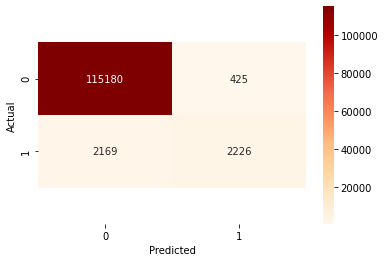

In [0]:
pred_over=np.zeros(y_scores_n.shape)
for line in range(y_scores_n.shape[0]):
    for item in range(y_scores_n.shape[1]):
        if y_scores_n[line,item] > 0.5:
            pred_over[line,item] = 1
        else:
            pred_over[line,item] = 0
s_totals_mat = confusion_matrix(y_test.astype(int).ravel(), pred_over.astype(int).ravel())
plot_conf_mat(s_totals_mat)

In [0]:
calc_scores(y_test.astype(int), pred_over.astype(int))

--------------------------------------------------
The macro averaged sensitivity/recall is: 2.28%
The macro averaged specificity is: 97.80%
The macro averaged precision is: nan%
--------------------------------------------------


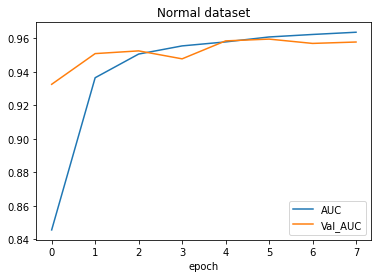

In [0]:

plt.plot(stuttHistory.history['auc_2'])
plt.plot(stuttHistory.history['val_auc_2'])
plt.xlabel('epoch')
plt.title("Normal dataset")
plt.legend(['AUC', 'Val_AUC'])
plt.show()

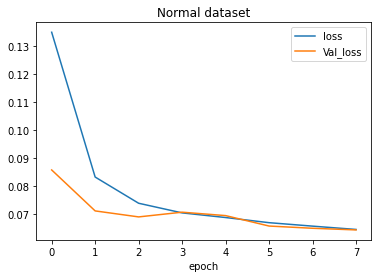

In [0]:
plt.plot(stuttHistory.history['loss'])
plt.plot(stuttHistory.history['val_loss'])
plt.xlabel('epoch')
plt.title("Normal dataset")
plt.legend(['loss', 'Val_loss'])
plt.show()

## Oversampled training starts

In [0]:
# Oversampled
df = Oversample(classes,train_data)
upsampled_x_train = df['comment_text'].to_numpy()
upsampled_y_train = df[classes].to_numpy()

upsampled_x_train, upsampled_y_train = getrandomSubset(upsampled_x_train,upsampled_y_train,datasetsize)

#Create train set from upsampled data and test set from original data
X_train, X_test = upsampled_x_train[0:int(datasetsize*0.8)], original_X_testData[0:int(datasetsize*0.2)]
y_train, y_test = upsampled_y_train[0:int(datasetsize*0.8)], original_Y_testData[0:int(datasetsize*0.2)]

assert len(X_train) == len(y_train)



print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

max_words = 1000 # <- spurning um hvað þetta eigi að vera

tokenizer = text.Tokenizer(num_words=max_words)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
tokTest = tokenizer.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(tokTrain, maxlen=256)
x_test=sequence.pad_sequences(tokTest, maxlen=256)

inp = Input(shape=(256,))

model = getModel()

| train_data shape: (80000,)
| 80000 train samples
| 20000 test samples


In [0]:
batch_size = 128
epochs = 6
overHistory = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,validation_split=0.2)
overScore = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



Train on 64000 samples, validate on 16000 samples
Epoch 1/6
64000/64000 [==============================] - 122s 2ms/sample - loss: 0.3179 - auc_3: 0.9265 - val_loss: 0.1961 - val_auc_3: 0.9733
Epoch 2/6
64000/64000 [==============================] - 123s 2ms/sample - loss: 0.1853 - auc_3: 0.9756 - val_loss: 0.1755 - val_auc_3: 0.9788
Epoch 3/6
64000/64000 [==============================] - 120s 2ms/sample - loss: 0.1656 - auc_3: 0.9804 - val_loss: 0.1679 - val_auc_3: 0.9828
Epoch 4/6
64000/64000 [==============================] - 119s 2ms/sample - loss: 0.1476 - auc_3: 0.9843 - val_loss: 0.1385 - val_auc_3: 0.9863
Epoch 5/6
64000/64000 [==============================] - 114s 2ms/sample - loss: 0.1305 - auc_3: 0.9875 - val_loss: 0.1217 - val_auc_3: 0.9891
Epoch 6/6
64000/64000 [==============================] - 116s 2ms/sample - loss: 0.1126 - auc_3: 0.9903 - val_loss: 0.1097 - val_auc_3: 0.9907


--------------------------------------------------
TN: 113010	 FP: 2475 
FN: 1409	 TP: 3106
The sensitivity/recall is: 68.79%
The specificity is: 97.86%
The precision is: 55.65%
--------------------------------------------------


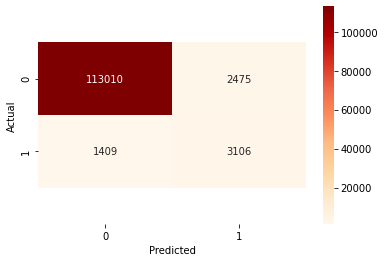

In [0]:
y_scores = model.predict(x_test,batch_size=128, verbose=1)
pred_n=np.zeros(y_scores.shape)
for line in range(y_scores.shape[0]):
    for item in range(y_scores.shape[1]):
        if y_scores[line,item] > 0.5:
            pred_n[line,item] = 1
        else:
            pred_n[line,item] = 0
s_totals_mat = confusion_matrix(y_test.astype(int).ravel(), pred_n.astype(int).ravel())
plot_conf_mat(s_totals_mat)

In [0]:
print(classification_report(y_test.astype(int), pred_n.astype(int), target_names=classes))
calc_precision_recall(y_test, y_scores, average_param = "micro", y_pred_ = pred_n )

               precision    recall  f1-score   support

        toxic       0.81      0.59      0.68      1947
 severe_toxic       0.40      0.62      0.49       222
      obscene       0.73      0.78      0.76      1077
       threat       0.39      0.40      0.40        67
       insult       0.61      0.75      0.67      1021
identity_hate       0.13      0.98      0.23       181

    micro avg       0.56      0.69      0.62      4515
    macro avg       0.51      0.69      0.54      4515
 weighted avg       0.69      0.69      0.67      4515
  samples avg       0.04      0.06      0.05      4515

F1 score: 0.615, AUC score: 0.955


In [0]:
calc_scores(y_test.astype(int), pred_n.astype(int))
from sklearn.metrics import classification_report
print(classification_report(y_test.astype(int),pred_n.astype(int)))

--------------------------------------------------
The macro averaged sensitivity/recall is: 68.77%
The macro averaged specificity is: 97.87%
The macro averaged precision is: 51.23%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.59      0.68      1947
           1       0.40      0.62      0.49       222
           2       0.73      0.78      0.76      1077
           3       0.39      0.40      0.40        67
           4       0.61      0.75      0.67      1021
           5       0.13      0.98      0.23       181

   micro avg       0.56      0.69      0.62      4515
   macro avg       0.51      0.69      0.54      4515
weighted avg       0.69      0.69      0.67      4515
 samples avg       0.04      0.06      0.05      4515



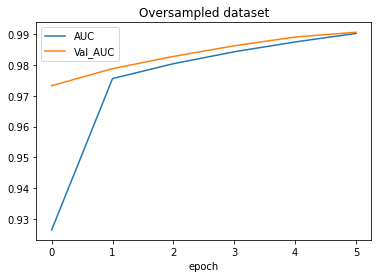

In [0]:
plt.plot(overHistory.history['auc_3'])
plt.plot(overHistory.history['val_auc_3'])
plt.xlabel('epoch')
plt.title("Oversampled dataset")
plt.legend(['AUC', 'Val_AUC'])
plt.show()

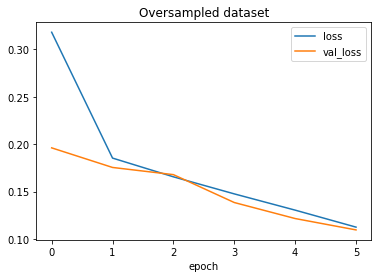

In [0]:
plt.plot(overHistory.history['loss'])
plt.plot(overHistory.history['val_loss'])
plt.xlabel('epoch')
plt.title("Oversampled dataset")
plt.legend(['loss', 'val_loss'])
plt.show()

In [0]:
testItems = ["I read a whole article about bike racing on Wikipedia", "My good friend, who is a muslim, has a black cat that","My buddy is gay, he has a black cat.  Heplays yatzee with a die."]
for item in testItems:
  tTest = tokenizer.texts_to_sequences([item])
  test_sentence = sequence.pad_sequences(tTest, maxlen=256)
  y_s = model.predict(test_sentence, verbose=1)
  pred_Test = np.where(y_s>0.5,1,0)
  print(pred_Test)

[[0 0 0 0 0 0]]
[[1 0 1 0 1 1]]
[[1 0 1 0 1 1]]


In [0]:
print(classes[0],
classes[2],
classes[4],
classes[5])

In [0]:
def plot_roc_curve(y_true_, y_score_, n_classes = 6, show_all_classes = False, model_name = ''):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_[:, i], y_score_[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_.ravel(), y_score_.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    if(show_all_classes):
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'crimson', 'indigo', 'limegreen'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of {} (area = {:0.2f})'
                     ''.format(cols[i+1], roc_auc[i]))
    plt.grid(None) 
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of {} model'.format(model_name))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Get Model

In [0]:
def getModel():
  stuttModel = Sequential()
  stuttModel = Embedding(max_words, 333)(inp) # 333 meðaltal athugasemda lengda 
#Embedded útskýring:
  #Turns positive integers (indexes) into dense vectors of fixed size.
######

#####
  stuttModel = GRU(128)(stuttModel)

  stuttModel = Dense(64, activation="relu")(stuttModel)
  stuttModel = Dense(num_classes, activation="sigmoid")(stuttModel)
  stuttModel = Model(inputs=inp, outputs=stuttModel)
  stuttModel.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=[tf.keras.metrics.AUC()])
  return stuttModel

In [0]:
from sklearn.metrics import *
def calc_precision_recall(y_true, y_scores, average_param = "micro", y_pred_ = None ):
    # Dæmi um notkun calc_precision_recall(y_test_np, y_scores, y_pred_ = y_test_pred)
    # y_scores is the decision function 
    # For each class
    # average_param has to be one of (None, 'micro', 'macro', 'weighted', 'samples')
    # micro = Calculate metrics globally by considering each element of the label indicator matrix as a label
    # macro = reiknar average_precision_score fyrir hvern label (hér: toxic...) og tekur óvigtað meðaltal
    # Ættum helst að nota micro held ég
    # y_scores er decision function sem segir hvoru megin (og hve langt frá) við aðskilnaðarplanið sem 
    # classfierinn býr til
    # no_skill baseline classifier giskar randomly
    # betra að nota random gisk hérna því all-zero gisk gefur 0 precision
    if y_pred_ is not None:
        # calculate F1 score
        f1 = f1_score(y_true, y_pred_, average = average_param)
        auc = roc_auc_score(y_true, y_scores, average = average_param)
        print("F1 score: {:.3f}, AUC score: {:.3f}".format(f1, auc))
        
    r_model = np.random.randint(2, size=len(y_true.ravel()))
    no_skill = precision_recall_curve(y_true.ravel(), r_model)
    
    precision = dict()
    recall = dict()
    average_precision = dict()

    # A "micro-average": quantifying score on all classes jointly
    precision[average_param], recall[average_param], _ = precision_recall_curve(y_true.ravel(),
        y_scores.ravel())
    average_precision[average_param] = average_precision_score(y_true, y_scores,
                                                         average=average_param)
    
    # plot_precision_recall(recall, precision, average_param, average_precision, no_skill)